In [429]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [430]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
from scipy import stats

from sonar import sonar, utils
import math

In [494]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = [
    'background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [506]:
relevant_cluster_labels =  [
     'background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

In [432]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

In [5]:
plt.figure(figsize=[10,10])

n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

<Figure size 1000x1000 with 0 Axes>

In [551]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=True)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:204: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


## 1) Simple plot

In [552]:
def simple_cooc_plot(cooc_curves_res, cell_type = "all", cell_type_labels = cluster_labels, um_per_px=1.0, y_zoom = 0.1): #cell_type_labels should be changed
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int or 'all'. 'all' by default to plot all cell types. Can be customized by choosing spesific cell-type number.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_ylim(-0.01, y_zoom)

    # X = 
    # Y = 

    if cell_type == "all":
        for i in range(1,16): # under 0 there is a background, so it should start from 1
            Y = cooc_curves_res[i,i]
            ax.plot(np.arange(len(Y))*um_per_px, Y)
        ax.legend(cell_type_labels[1:14], loc="upper right", bbox_to_anchor=(1.45, 1)) # specific case for pancreas, needs to be more general
        ax.set_title(f"Auto-co-occurrence of all cell types")
    else:
        Y = cooc_curves_res[cell_type,cell_type]
        ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
        ax.legend(loc="upper right")
        ax.set_title(f"Auto-co-occurrence of {cluster_labels[cell_type]} cell-type")


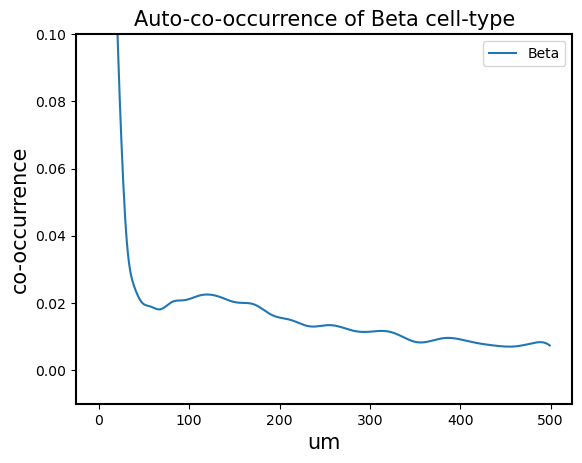

In [553]:
simple_cooc_plot(cooc_curves_res = cooc_template_, cell_type_labels = cluster_labels, cell_type = 7, y_zoom = 0.1)

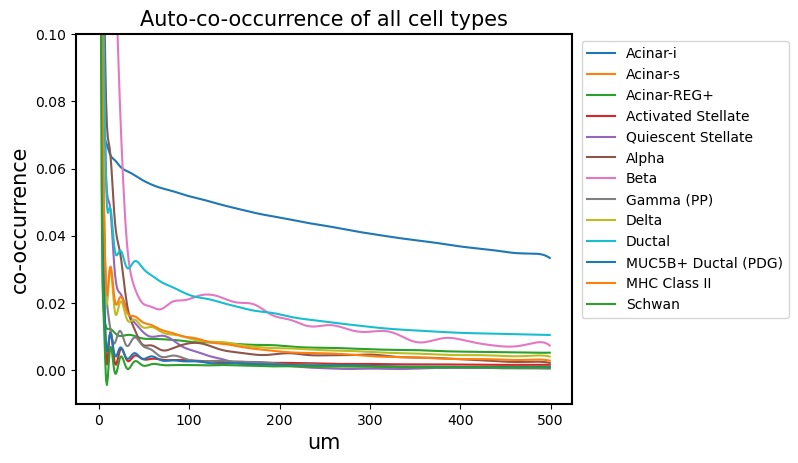

In [554]:
simple_cooc_plot(cooc_curves_res = cooc_template_, cell_type_labels = cluster_labels,  y_zoom = 0.1)

Text(0.5, 1.0, 'Auto-co-occurrence of Beta cell-type')

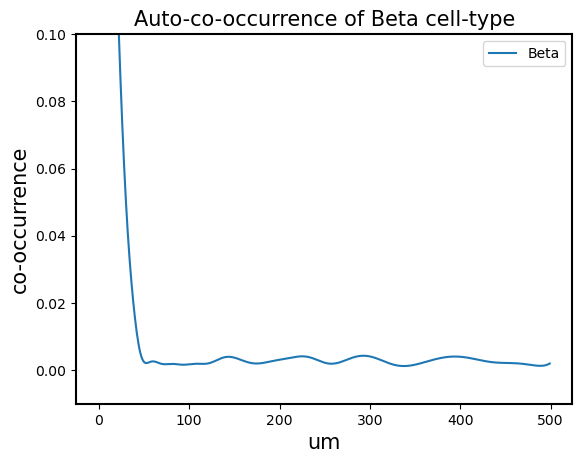

In [436]:
um_per_px = 1
Y = cooc_template_[7,7]

fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

ax.plot(np.arange(len(Y))*um_per_px, Y, label=cluster_labels[7])
ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type")

## 2) Co-occurrence with computed radii

In [437]:
def cooc_with_computed_radii(cooc_curves_res, cell_type, radii, cell_type_labels = cluster_labels, um_per_px = 1.0, y_zoom = 0.1): #cell_type_labels should be changed
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int, selected cell-type number.
    - rad_: int, selected radii
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")
    ax.set_ylim(-0.01, y_zoom)

    Y = cooc_curves_res[cell_type,cell_type]

    ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cluster_labels[cell_type]} cell-type with computed radii")

    # plot radii
    for rad_ in list(range(radii,500,radii)):
        ax.axvline(rad_, linewidth=0.5, color='orange')


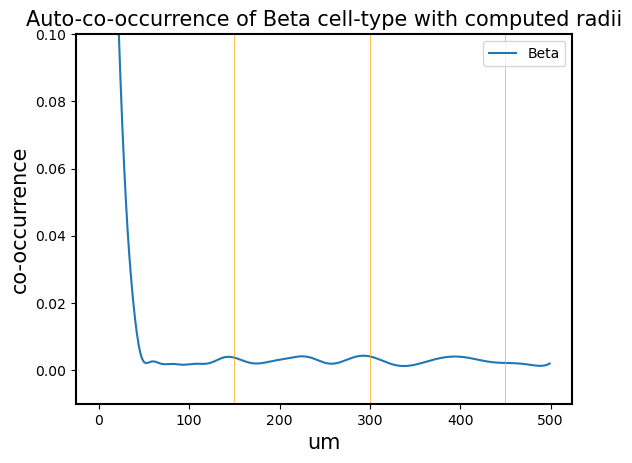

In [438]:
cooc_with_computed_radii(cooc_curves_res=cooc_template_, cell_type=7, radii=150)

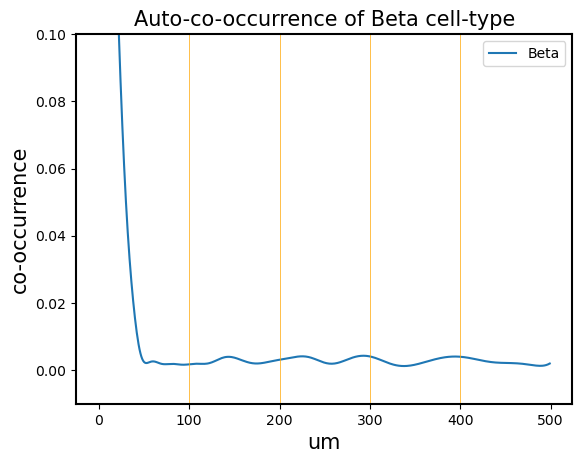

In [439]:
fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

ax.plot(cooc_template_[int(7),int(7)], label=cluster_labels[int(7)])
ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type")


for i in list(range(100,500,100)):
    ax.axvline(i, linewidth=0.5, color='orange')

## 3) Curve with error margins:

In [440]:
def cooc_with_error_margins(cooc_curves_res, cell_type, error_margin, cell_type_labels = cluster_labels, um_per_px=1.0, y_zoom = 0.1): #cell_type_labels should be changed
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int, selected cell-type number.
    - error_margin: float, passed error margin value
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter. 
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_ylim(-0.01, y_zoom)

    Y = cooc_curves_res[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px # x axis of the plot

    # plots preparation
    initial_plot = Y
    min_error = Y-error_margin
    max_error = Y+error_margin

    # ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])

    # margin error plotting
    ax.plot(X, initial_plot, label=cell_type_labels[cell_type], color = 'b')
    ax.plot(X, min_error, color = 'orange', linewidth = 0.001)
    ax.plot(X, max_error, color = 'orange', linewidth = 0.001)
    ax.fill_between(x=X, y1=min_error, y2=max_error, color = 'orange', alpha = 0.5)

    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type with margin errors")

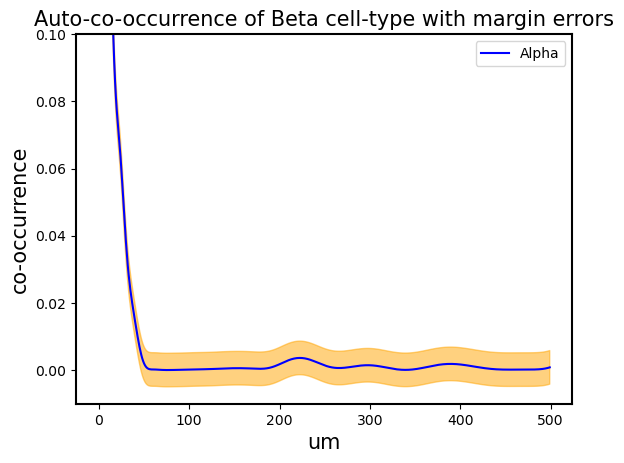

In [441]:
cooc_with_error_margins(cooc_curves_res=cooc_template_, cell_type=6, error_margin=0.005)

Text(0.5, 1.0, 'Auto-co-occurrence of Beta cell-type with margin errors')

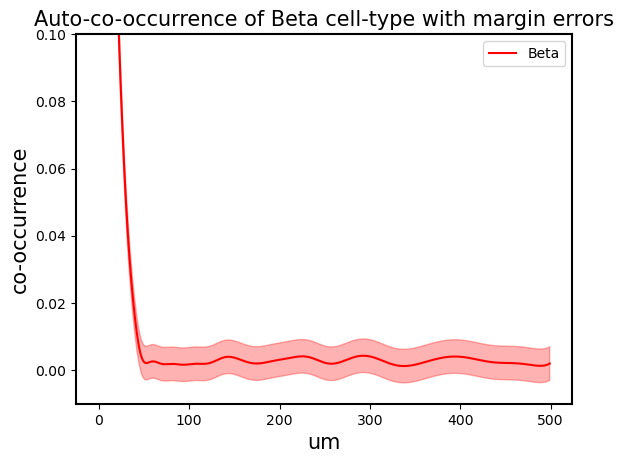

In [442]:
# trial for the previour function
fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

initial_plot = cooc_template_[int(7),int(7)]
min_error = cooc_template_[int(7),int(7)]-0.005
max_error = cooc_template_[int(7),int(7)]+0.005

X = list(range(cooc_template_.shape[2]))

ax.plot(initial_plot, label=cluster_labels[7], color = 'r')
ax.plot(min_error, color = 'r', linewidth = 0.001)
ax.plot(max_error, color = 'r', linewidth = 0.001)
ax.fill_between(x=X, y1=min_error, y2=max_error, color = 'r', alpha = 0.3)

ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type with margin errors")

## 4) Plot with significance indicatior

In [443]:
# creation of a training set for the future function
# irrelevant for other scales and different um/px
"""Task: to develop a proper function for selection of the significant areas in the array
"""
zer_ar = np.zeros(500)
zer_ar[0:60] = 1
zer_ar[190:250] = 1
zer_ar[280:330] = 1
zer_ar[360:420] = 1

bool_ar = zer_ar.astype(bool)

In [444]:
def significance_ident(cooc_curves_res, cell_type, bool_array, 
                       cell_type_labels = cluster_labels, um_per_px=1, y_zoom = 1.0): #cell_type_labels should be changed
    """
    Indicates 'significant' areas of the co-occurrence plot 
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int number, selected cell type.
    - bool_array: boolean array indicating distances of 'significance'.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """

    # preprocessing of the boolean array to recieve edges of highlighted areas
    dist_list = []
    for pos, value in enumerate(bool_ar):
        if value != bool_ar[pos-1]:
            dist_list.append(pos)

    # plotting of the significant areas
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")
    ax.set_title(f"Significance indication plot of {cell_type_labels[cell_type]} cell-type auto-co-occurrence")

    Y = cooc_template_[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px

    ax.plot(X, Y)
    ax.set_ylim(-0.001,y_zoom)

    for i in range(0,len(dist_list),2):

        ax.axvspan(dist_list[i], dist_list[i+1], alpha = 0.3, color = "orange")
    

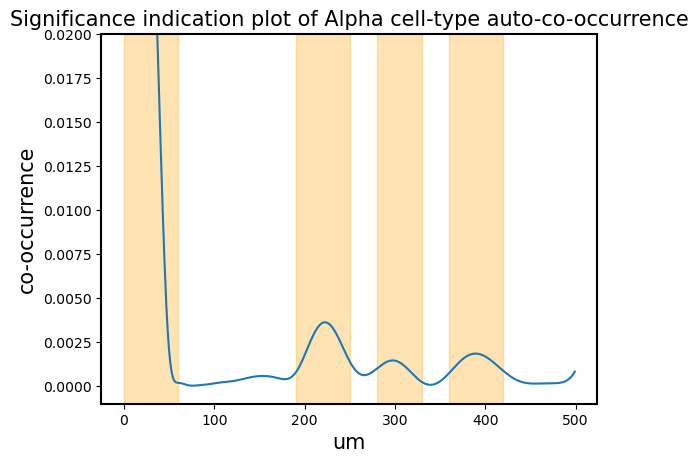

In [445]:
significance_ident(cooc_curves_res = cooc_template_, cell_type=6, bool_array=bool_ar, 
                       cell_type_labels = cluster_labels, y_zoom=0.02)

## 5) stacked local distributions

In [555]:
""" Tasks:
- to add expected values on the right hand side of the plot
- cell_type_labels should be changed
"""

def stacked_cooc_plot(cooc_curves_res, cell_type, cell_type_labels = cluster_labels, um_per_px = 1.0):
                    #   show_bg = True): #cell_type_labels should be changed
    """
    Plots stacked co-occurrence plots which shows their distribution over different distances
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int number, selected cell type.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - show_bg: bool, True by default. Shows the distribution of the background.
    """

    # preparation of the list of cell-types that are to be generated after the selected cell-type
    cell_type_sum = 0
    ct_list = list(range(1,14))
    ct_list.remove(cell_type)
    cell_type_sum = cooc_curves_res[cell_type,cell_type].copy()
    x = list(range(0,500))

    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_title(f"Stacked local distribution of {cell_type_labels[cell_type]} cell-type VS other cell-types")

    # plotting of a selected cell-type
    ax.plot(cell_type_sum, linewidth=0.5, label=cluster_labels[cell_type])
    ax.fill_between(x,cell_type_sum,0)

     # plotting of other cell-types
    for i in ct_list:
        Y = cooc_curves_res[cell_type,i]
        X = np.arange(len(Y))*um_per_px
        prev = cell_type_sum.copy()
        cell_type_sum += Y
        ax.fill_between(x,cell_type_sum,prev, alpha = 0.5)
        ax.plot(cell_type_sum, label=cluster_labels[i], linewidth=0.5)

    # # plotting a background if needed
    # if show_bg == True:
    #     bg = cell_type_sum + cooc_curves_res[cell_type,0]
    #     ax.plot(bg, label=cluster_labels[0], linewidth=0.5)
    #     ax.fill_between(x,cell_type_sum,bg, alpha = 0.5)


    # get the legend object
    leg = ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)

    plt.show()

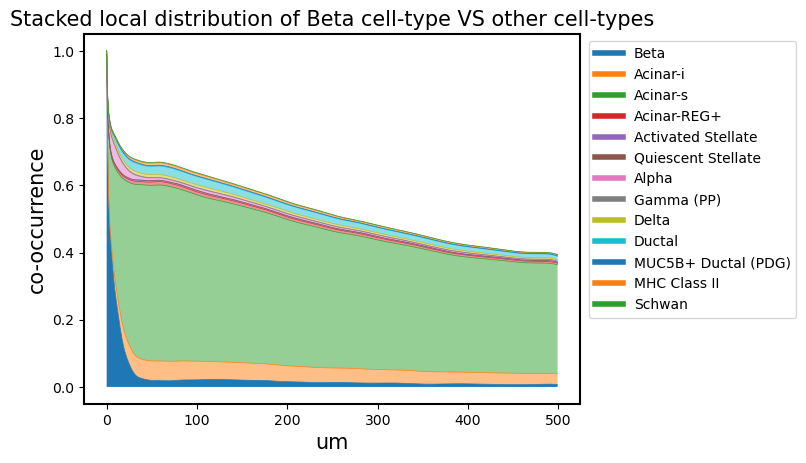

In [556]:
stacked_cooc_plot(cooc_template_, 7)

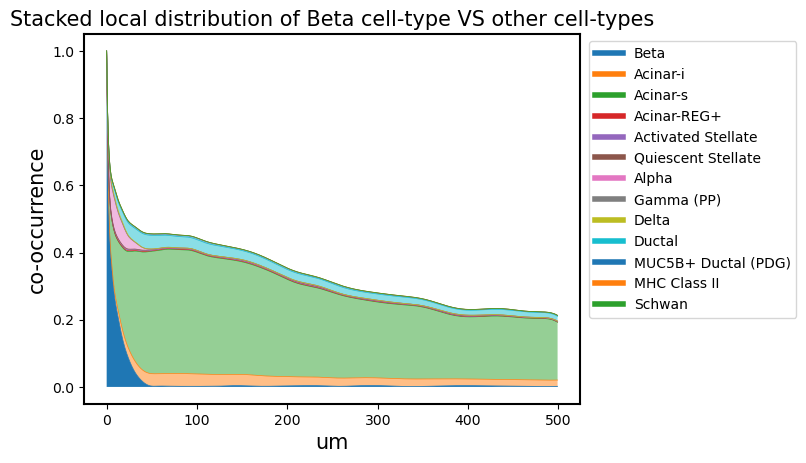

In [448]:
# function parameteres
cooc_curves_res = cooc_template_
cell_type = 7
cell_type_labels = cluster_labels
um_per_px = 1.0


# preparation of the list of cell-types that are to be generated after the selected cell-type
cell_type_sum = 0
ct_list = list(range(1,14))
ct_list.remove(cell_type)
cell_type_sum = cooc_curves_res[cell_type,cell_type].copy()

Y = cooc_curves_res[cell_type,cell_type]  #/tissue_pixels[i]
X = np.arange(len(Y))*um_per_px

# calculation of the tissue area of each cell-type
tissue_pixels = []
for i in ct_list:
    pix_agreg = np.sum(rescaled[i])
    tissue_pixels.append(pix_agreg)

fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um") 
ax.set_title(f"Stacked local distribution of {cell_type_labels[cell_type]} cell-type VS other cell-types")

# plotting of a selected cell-type
ax.plot(cell_type_sum, linewidth=0.5, label=cluster_labels[cell_type])
ax.fill_between(X,cell_type_sum,0)

# plotting of other cell-types
for i in ct_list:
    Y = cooc_curves_res[cell_type,i]  #/tissue_pixels[i]
    X = np.arange(len(Y))*um_per_px
    prev = cell_type_sum.copy()
    cell_type_sum += Y
    ax.fill_between(X,cell_type_sum,prev, alpha = 0.5)
    ax.plot(cell_type_sum, label=cluster_labels[i], linewidth=0.5)

    # get the legend object
leg = ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

    # change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

# ax.set_ylim(-0.01, 0.4)

plt.show()

### Normalisation to the number of pixels

2750872.0
97550.0
984839.0
14495.0
4537.0
2790.0
7951.0
20647.0
1322.0
10936.0
32367.0
2125.0
7883.0
2347.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'background'),
  Text(1, 0, 'Acinar-i'),
  Text(2, 0, 'Acinar-s'),
  Text(3, 0, 'Acinar-REG+'),
  Text(4, 0, 'Activated Stellate'),
  Text(5, 0, 'Quiescent Stellate'),
  Text(6, 0, 'Alpha'),
  Text(7, 0, 'Beta'),
  Text(8, 0, 'Gamma (PP)'),
  Text(9, 0, 'Delta'),
  Text(10, 0, 'Ductal'),
  Text(11, 0, 'MUC5B+ Ductal (PDG)'),
  Text(12, 0, 'MHC Class II'),
  Text(13, 0, 'Schwan')])

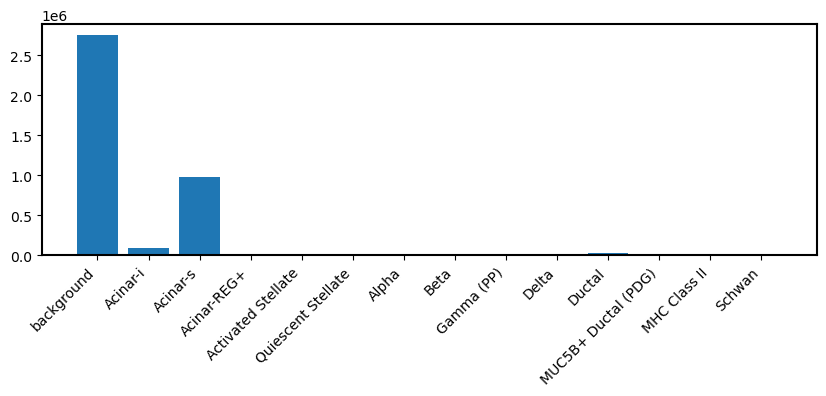

In [527]:
# calculation of the tissue area of each cell-type
plt.figure(figsize=[10,3])
tissue_pixels = []
for i in range(len(relevant_cluster_labels)):
    pix_agreg = np.sum(rescaled[i])
    tissue_pixels.append(pix_agreg)
    print(pix_agreg)

plt.bar(relevant_cluster_labels,tissue_pixels)
plt.xticks(rotation=45, ha="right")

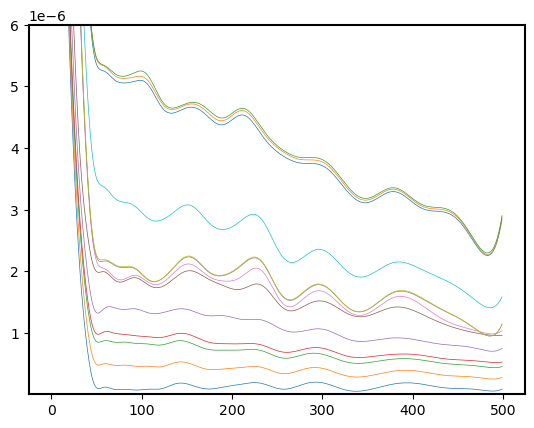

In [550]:
# Specific cell-type

fig, ax = plt.subplots()
cell_type = 7

ct_list = list(range(1,14))
ct_list.remove(cell_type)

cell_type_sum = cooc_curves_res[cell_type,cell_type].copy()/tissue_pixels[cell_type]
ax.plot(cell_type_sum, label=relevant_cluster_labels[cell_type], linewidth=0.5)

for i in ct_list:
    
    Y = cooc_curves_res[cell_type,i]/tissue_pixels[i]
    X = np.arange(len(Y))*um_per_px
    cell_type_sum += Y
    ax.plot(cell_type_sum, label=relevant_cluster_labels[i], linewidth=0.5)

    # ax.fill_between(X,cell_type_sum,prev, alpha = 0.5)

plt.ylim(10**(-8), 6*10**(-6))    
plt.show()


cooc_curves_res[7,5]


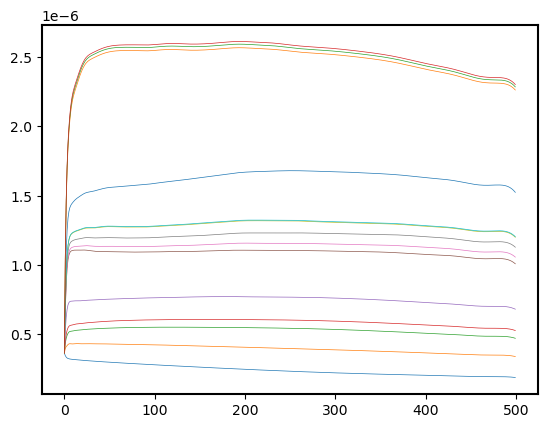

In [557]:
# Non-specific

fig, ax = plt.subplots()

cell_type_sum = cooc_curves_res[0,0].copy()/tissue_pixels[0]
ax.plot(cell_type_sum, label=relevant_cluster_labels[0], linewidth=0.5)

for i in range(1,len(tissue_pixels)):
    
    Y = cooc_curves_res[0,i]/tissue_pixels[i]
    X = np.arange(len(Y))*um_per_px
    cell_type_sum += Y
    ax.plot(cell_type_sum, label=relevant_cluster_labels[i], linewidth=0.5)

2750872.0
97550.0
984839.0
14495.0
4537.0
2790.0
7951.0
20647.0
1322.0
10936.0
32367.0
2125.0
7883.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Acinar-i'),
  Text(1, 0, 'Acinar-s'),
  Text(2, 0, 'Acinar-REG+'),
  Text(3, 0, 'Activated Stellate'),
  Text(4, 0, 'Quiescent Stellate'),
  Text(5, 0, 'Alpha'),
  Text(6, 0, 'Beta'),
  Text(7, 0, 'Gamma (PP)'),
  Text(8, 0, 'Delta'),
  Text(9, 0, 'Ductal'),
  Text(10, 0, 'MUC5B+ Ductal (PDG)'),
  Text(11, 0, 'MHC Class II'),
  Text(12, 0, 'Schwan')])

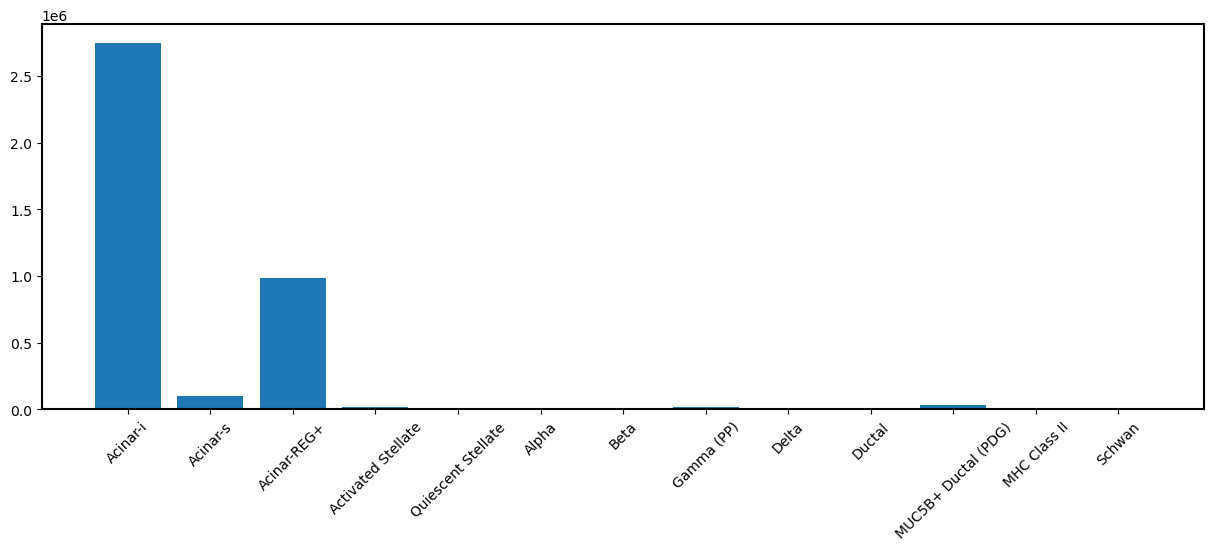

In [498]:
print(len(tissue_pixels))
print(len(relevant_cluster_labels))

13
13


In [558]:
cooc_template_.shape

(16, 16, 500)

In [567]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=True)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

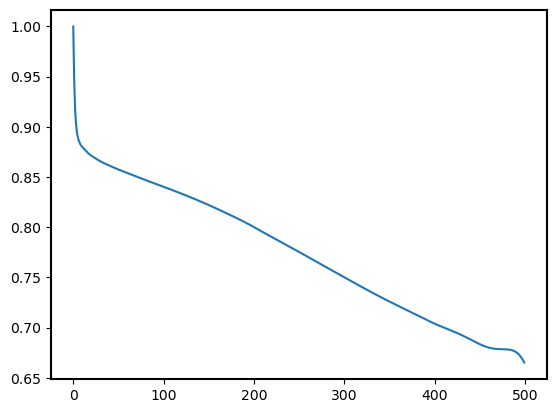

In [568]:
plt.plot(cooc_template_[0,0])

In [565]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=False)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

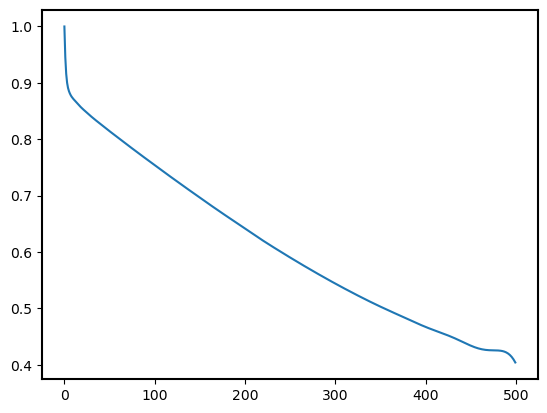

In [566]:

plt.plot(cooc_template_[0,0])


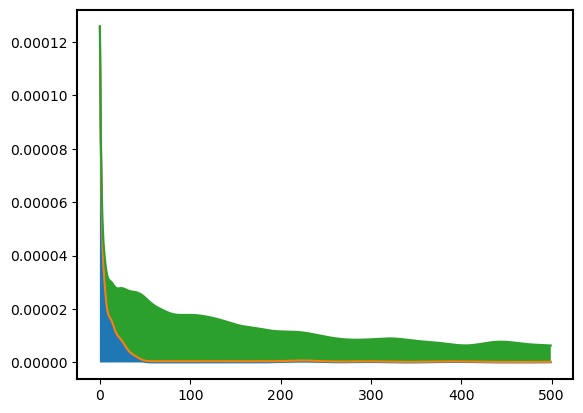

In [488]:
# Trial of the upper function

a = cooc_template_[6,6]/tissue_pixels[5] + cooc_template_[6,2]/tissue_pixels[1]
b = a + cooc_template_[6,10]/tissue_pixels[9]
plt.plot(cooc_template_[6,6]/tissue_pixels[5])
plt.plot(a)
plt.plot(b)

plt.fill_between(list(range(0,500)),cooc_template_[6,6]/tissue_pixels[5],0)
plt.fill_between(list(range(0,500)),cooc_template_[6,6]/tissue_pixels[5],a)
plt.fill_between(list(range(0,500)),a,b)

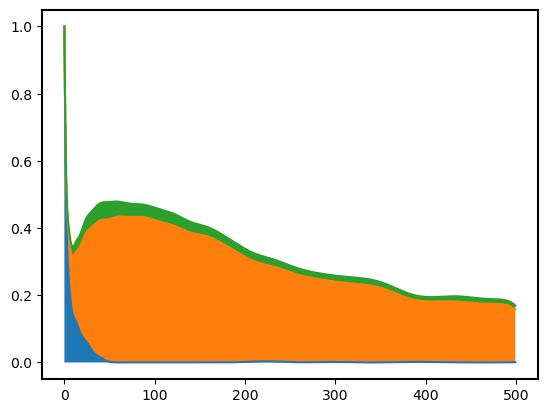

In [487]:
# Trial of the upper function

a = cooc_template_[6,6] + cooc_template_[6,2]
b = a + cooc_template_[6,10]
plt.plot(cooc_template_[6,6])
plt.plot(a)
plt.plot(b)

plt.fill_between(list(range(0,500)),cooc_template_[6,6],0)
plt.fill_between(list(range(0,500)),cooc_template_[6,6],a)
plt.fill_between(list(range(0,500)),a,b)

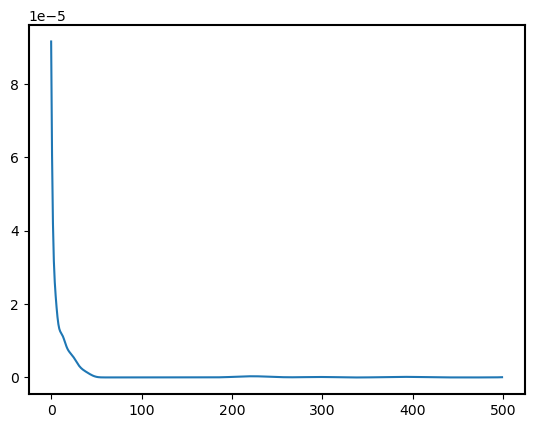

In [486]:
plt.plot(cooc_template_[6,6]/tissue_pixels[7])

    